# libraries

In [20]:
import librosa
#import librosa.display
import setuptools

from numpy.distutils.core import setup
%pylab inline --no-import-all
#from scikits.audiolab import wavread
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import math
import numpy as np
from numpy.fft import fft
import pylab
#import mir_eval
import seaborn
seaborn.set(style="ticks")

Populating the interactive namespace from numpy and matplotlib


/home/mlbd/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
import numpy as np
from matplotlib import pyplot as pl
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

# functions

In [22]:
# load audio file function
def loadsingal(filename):
    signal ,sample_rate=librosa.load(filename,sr=12000, mono=True)
    signal=signal#[int(2.5 * sample_rate):int(3.0 * sample_rate)] 
    return signal ,sample_rate

In [23]:
# add silence in the end of audio file 
def comp_audio(data, fs, T):
    # Calculate target number of samples
    N_tar = int(fs * T)
    # Calculate number of zero samples to append
    shape = data.shape
    # Create the target shape    
    N_pad = N_tar - shape[0]
    # print("Padding with %s seconds of silence" % str(N_pad/fs) )
    shape = (N_pad,) + shape[1:]
    # Stack only if there is something to append    
    if shape[0] > 0:                
        if len(shape) > 1:
            return np.vstack((np.zeros(shape),
                              data))
        else:
            return np.hstack((np.zeros(shape),
                              data))
    else:
        return data

In [24]:
# convert audio in spectrogram
from scipy import signal
def spectrogram(signals,plot=False,sample_rate=12000):
    Sxxs=[]
    for i,data in enumerate(signals):
        f, t, Sxx = signal.spectrogram(data,sample_rate)
        Sxxs.append(Sxx)
       
        if plot==True:
            plt.pcolormesh(t, f, Sxx)
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.grid()
            plt.show()
    return Sxxs

# Data loading

In [25]:
from sklearn.model_selection import train_test_split
import glob, os
dir ="/scratch/mlbd/"
# changes current working directory
os.chdir(dir+"BECASSE_FILTREE")
filenames=[]
for file in glob.glob("*.wav"):
    filenames.append('/BECASSE_FILTREE/'+file)
    
# changes current working directory
os.chdir(dir+"NO_BECASSE_FILTREE")
filenames_N=[]
for file in glob.glob("*.wav"):
    filenames_N.append('NO_BECASSE_FILTREE/'+file)

nb_Files=1000
filenames=filenames[:nb_Files]
filenames_N=filenames_N[:nb_Files]
signals=[]
signals_N=[]
time=float(30)

# load becasse audio file
for filename in filenames:
    path=dir +filename
    s ,sample_rate=loadsingal(path)
    #complete audio with fonction comp_audio to have commune size
    s_t=comp_audio(s,sample_rate,time)
    signals.append(s_t)
    
# load no_becasse audio file
for filename in filenames_N:
    path=dir +filename
    s_N ,sample_rate_N=loadsingal(path)
    s_N_t=comp_audio(s_N,sample_rate_N,time)
    signals_N.append(s_N_t)


# Data processing and preparation   

In [26]:
# load spectrogram of becase 
X_data_B=np.asarray(spectrogram(signals,False,sample_rate))
y_data_B=np.ones(len(X_data_B))  # 1:becasse, o: non becasse

# load spectrogram of non-becase 
data_inter=spectrogram(signals_N,False,sample_rate)

# delete error rows from "non becasse" sampling
rows_to_delete =[]
for i in range(len(data_inter)):
    if data_inter[i].shape[0] <> 129 or data_inter[i].shape[1] <> 1607:
        rows_to_delete.append(i)
        
for i,row in enumerate(rows_to_delete):
    del data_inter[row]   
        
# load spectrogram of non-becase final
X_data_N=np.asarray(data_inter)
y_data_N=np.zeros(len(X_data_N))  # 1:becasse, o: non becasse

# combine data "becasse" and "no becasse"
X_data = np.concatenate((X_data_B, X_data_N),axis=0)
y_data = np.concatenate((y_data_B ,y_data_N),axis=0)


In [27]:
# sampling data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
                        X_data, y_data, test_size=0.3, stratify=y_data)

print "X_train.shape : ", X_train.shape
print "y_train.shape : ", y_train.shape
print "X_test.shape : ", X_test.shape
print "y_test.shape : ", y_test.shape


n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, 1, height, width).astype('float32')
X_test = X_test.reshape(n_test, 1, height, width).astype('float32')

maxi_train_value=np.max(X_train[2])
maxi_test_value=np.max(X_test[2])


X_train /= float(maxi_train_value)
X_test /= float(maxi_test_value)

n_classes = 2

print n_train, 'train samples'
print n_test, 'test samples'

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

X_train.shape :  (14, 129, 1607)
y_train.shape :  (14,)
X_test.shape :  (6, 129, 1607)
y_test.shape :  (6,)
14 train samples
6 test samples


# Data modeling

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
def create_model():
    # create model
    model = Sequential()

    model.add(Convolution2D(9, 5, 5, activation='relu', input_shape=(1, height, width)))
    #model.add(Convolution2D(9, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    #model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()

    # Compile model
    keras.optimizers.RMSprop(lr=0.0000000000000001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    return model

In [29]:
print X_train.shape
print Y_train.shape

print X_test.shape
print Y_test.shape


(14, 1, 129, 1607)
(14, 2)
(6, 1, 129, 1607)
(6, 2)


In [30]:
batch_size = 128
n_epoch = 10
model=create_model()
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    nb_epoch=n_epoch, verbose=1, validation_data=(X_test, Y_test))

/home/mlbd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(9, (5, 5), activation="relu", input_shape=(1, 129, 1...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 9, 125, 1603)      234       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 62, 801)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 62, 801)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 446958)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 446958)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 893918    
Total params: 894,152.0
Trainable params: 894,152.0
Non-trainable params: 0.0
________________________________________________________________

('Train score:', 0.38383916020393372)
('Train accuracy:', 1.0)
('Test score:', 0.76343202590942383)
('Test accuracy:', 0.5)


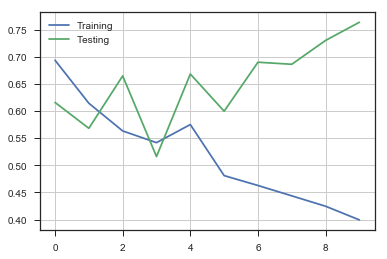

In [31]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_train, Y_train, verbose=0)
print('Train score:', score[0])
print('Train accuracy:', score[1])


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [32]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

6/6 [==============================] - 0s
Confusion matrix, without normalization
[[3 0]
 [3 0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


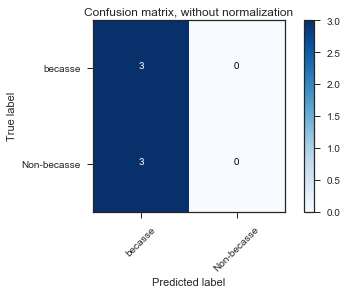

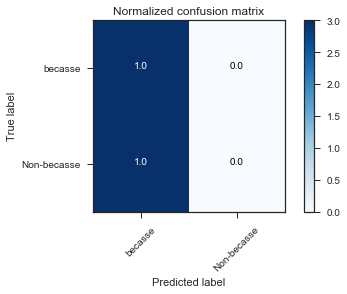

In [33]:
import sklearn.metrics as skmetrics
y_test_pred=model.predict_classes(X_test)
class_names=['becasse', 'Non-becasse']
cnf_matrix = skmetrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [34]:
#A regarder si on a le temps
'''from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
batch_size = 128
n_epoch = 2

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y = encoder.transform(Y_train)

seed = 7
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=n_epoch, batch_size=batch_size, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X_train, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
'''

'from keras.wrappers.scikit_learn import KerasClassifier\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.preprocessing import LabelEncoder\nbatch_size = 128\nn_epoch = 2\n\n# encode class values as integers\nencoder = LabelEncoder()\nencoder.fit(Y_train)\nencoded_Y = encoder.transform(Y_train)\n\nseed = 7\nestimators = []\nestimators.append((\'standardize\', StandardScaler()))\nestimators.append((\'mlp\', KerasClassifier(build_fn=create_model, epochs=n_epoch, batch_size=batch_size, verbose=0)))\npipeline = Pipeline(estimators)\nkfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)\nresults = cross_val_score(pipeline, X_train, encoded_Y, cv=kfold)\nprint("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))\n'